<a href="https://colab.research.google.com/github/amilkh/cs230-fer/blob/75-soa/fer2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.4

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.lib.io import file_io

import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

%matplotlib inline

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.5


In [0]:
EPOCHS = 300
BS = 128
DROPOUT_RATE = 0.4
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

#data = pd.read_csv('/content/drive/My Drive/cs230 project/collab/fer2013/fer2013.csv')

data = pd.read_csv('/content/drive/My Drive/cs230 project/collab/fer2013/icml_face_data.csv') 

print(data.head())

print(data.columns)

data_train = data[data[' Usage'] == 'Training']

print('Number samples in the training dataset: ', data_train.shape[0])
data_dev = data[data[' Usage'] == 'PublicTest']

print('Number samples in the development dataset: ', data_dev.shape[0]) 
print(data_dev.head())
data_test = data[data[' Usage'] == 'PrivateTest']

print('Number samples in the development dataset: ', data_dev.shape[0]) 
print(data_test.head())
data_train.to_csv('/content/drive/My Drive/cs230 project/collab/fer2013/train.csv') 
data_dev.to_csv('/content/drive/My Drive/cs230 project/collab/fer2013/dev.csv') 
data_test.to_csv('/content/drive/My Drive/cs230 project/collab/fer2013/test.csv')

print(data_train.shape) 
print(data_dev.shape) 
print(data_test.shape)

In [0]:
# Function that reads the data from the csv file, increases the size of the images and returns the images and their labels
    # dataset: Data path
def get_data(dataset):
    
    file_stream = file_io.FileIO(dataset, mode='r')
    data = pd.read_csv(file_stream)

    #data = pd.read_csv('fer2013/fer2013.csv')
    data[' pixels'] = data[' pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])

    # Retrieve train input and target
    X, Y = data[' pixels'].tolist(), data['emotion'].values
    
    # Reshape images to 4D (num_samples, width, height, num_channels)
    X_res = np.array(X, dtype='float32').reshape(-1,48,48,1)
    # Normalize images with max (the maximum pixel intensity is 255)
    X_res = X_res/255.0
    #image_resized = resize(image, (image.shape[0] // 4, image.shape[1] // 4), anti_aliasing=True)

    Y_res = np.zeros((Y.size, 7))
    Y_res[np.arange(Y.size),Y] = 1    
    
    return  X_res, Y_res

In [0]:
training_dataset_dir = '/content/drive/My Drive/cs230 project/collab/fer2013/train.csv'
dev_dataset_dir = '/content/drive/My Drive/cs230 project/collab/fer2013/dev.csv'
# Data preparation
X_train, Y_train  = get_data(training_dataset_dir)
X_dev, Y_dev      = get_data(dev_dataset_dir)

# Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches) indefinitely
# rescale:          Rescaling factor (defaults to None). Multiply the data by the value provided (before applying any other transformation)
# rotation_range:   Int. Degree range for random rotations
# shear_range:      Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
# zoom_range:       Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]
# fill_mode :       Points outside the boundaries of the input are filled according to the given mode: {"constant", "nearest", "reflect" or "wrap"}
# horizontal_flip:  Boolean. Randomly flip inputs horizontally
# train_datagen = ImageDataGenerator(
#     rotation_range  = 10,
#     shear_range     = 5, # 10 degrees
#     zoom_range      = 0.1,
#     fill_mode       = 'reflect',
#     horizontal_flip = True)

# train_datagen = ImageDataGenerator(
#         rotation_range=15,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         horizontal_flip=True,
#         zoom_range=0.2)

train_datagen = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

# Takes numpy data & label arrays, and generates batches of augmented/normalized data. Yields batcfillhes indefinitely, in an infinite loop
    # x:            Data. Should have rank 4. In case of grayscale data, the channels axis should have value 1, and in case of RGB data, 
    #               it should have value 3
    # y:            Labels
    # batch_size:   Int (default: 32)
train_generator = train_datagen.flow(X_train, Y_train,  batch_size  = BS)

# Implement below paper CPCPCPFF depth 5, 2.4m params
# http://openaccess.thecvf.com/content_cvpr_2016_workshops/w28/papers/Kim_Fusing_Aligned_and_CVPR_2016_paper.pdf
# Reference: https://arxiv.org/pdf/1612.02903.pdf
model = Sequential()
model.add(Conv2D(64, (5, 5), activation='relu',padding='same', input_shape=(48,48,1),name="conv1"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool1"))
model.add(Dropout(DROPOUT_RATE))
model.add(Conv2D(96, (5, 5), activation='relu',padding='same',name="conv2"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool2"))         
model.add(Dropout(DROPOUT_RATE))
model.add(Conv2D(256, (5, 5), activation='relu',padding='same',name="conv3"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool3"))
model.add(Conv2D(256, (5, 5), activation='relu',padding='same',name="conv4"))

model.add(Flatten())
model.add(Dense(2048, activation='relu',name='fc1'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax',name='fcsoftmax'))

#TODO: weight decay of 0.0001...initial learning rate is set to 0.01 and reduced by a factor of 2 at every 25 epoch
sgd = SGD(lr=SGD_LEARNING_RATE,momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [8]:
# Implement below paper CPCPCPFF depth 5, 2.4m params
# http://openaccess.thecvf.com/content_cvpr_2016_workshops/w28/papers/Kim_Fusing_Aligned_and_CVPR_2016_paper.pdf
# Reference: https://arxiv.org/pdf/1612.02903.pdf
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu',padding='same', input_shape=(48,48,1),name="conv1"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool1"))
#model.add(Dropout(DROPOUT_RATE))
model.add(Conv2D(32, (4, 4), activation='relu',padding='same',name="conv2"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool2"))         
#model.add(Dropout(DROPOUT_RATE))
model.add(Conv2D(64, (5, 5), activation='relu',padding='same',name="conv3"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool3"))
model.add(Flatten())
model.add(Dense(1024, activation='relu',name='fc1'))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(7, activation='softmax',name='fcsoftmax'))

#TODO: weight decay of 0.0001...initial learning rate is set to 0.01 and reduced by a factor of 2 at every 25 epoch
sgd = SGD(lr=SGD_LEARNING_RATE,momentum=0.9, decay=SGD_DECAY, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
#rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)
rlrop = ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [9]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=(X_dev, Y_dev), 
    steps_per_epoch=len(X_train) // BS,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=[rlrop]) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/300
224/224 [==============================] - 17s 77ms/step - loss: 1.8950 - acc: 0.2717 - val_loss: 1.6864 - val_acc: 0.3210
Epoch 2/300
224/224 [==============================] - 11s 48ms/step - loss: 1.7027 - acc: 0.3206 - val_loss: 1.5729 - val_acc: 0.3993
Epoch 3/300
224/224 [==============================] - 11s 47ms/step - loss: 1.6404 - acc: 0.3522 - val_loss: 1.5189 - val_acc: 0.4071
Epoch 4/300
224/224 [==============================] - 11s 48ms/step - loss: 1.5793 - acc: 0.3808 - val_loss: 1.4989 - val_acc: 0.4255
Epoch 5/300
224/224 [==============================] - 11s 47ms/step - loss: 1.5431 - acc: 0.3980 - val_loss: 1.6575 - val_acc: 0.3541
Epoch 6/300
224/224 [==============================] - 11s 49ms/step - loss: 1.5046 - acc: 0.4170 - val_loss: 1.4770 - val_acc: 0.4355
Epoch 7/300
224/224 [==============================] - 11s 49ms/step - loss: 1.4662 - acc: 0.4

In [10]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate(X_dev, Y_dev , batch_size=128)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
3589/3589 [==============================] - 0s 70us/step
dev loss, dev acc: [1.052624678904049, 0.648927277801561]


In [11]:
test_dataset_dir = '/content/drive/My Drive/cs230 project/collab/fer2013/test.csv'
X_test, Y_test      = get_data(test_dataset_dir)

print('\n# Evaluate on test data')
results_test = model.evaluate(X_test, Y_test , batch_size=128)
print('test loss, test acc:', results_test)


# Evaluate on test data
3589/3589 [==============================] - 0s 74us/step
test loss, test acc: [1.0130413163169973, 0.648927277801561]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


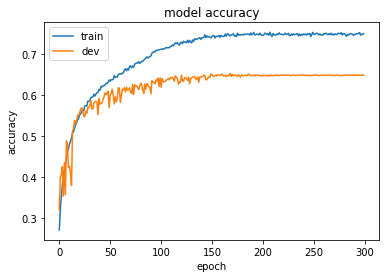

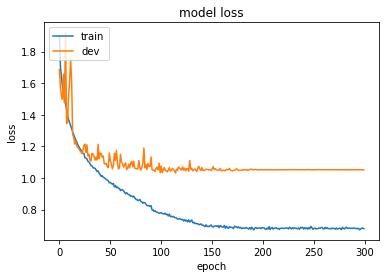

In [12]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [0]:
lr_str = '-SGD_LR_%.5f' % SGD_LEARNING_RATE
epoch_str = '-EPOCHS_' + str(EPOCHS)
bs_str = '-BS_' + str(BS)
dropout_str = '-DROPOUT_' + str(DROPOUT_RATE)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/cs230 project/models/soa' + lr_str + epoch_str + bs_str + dropout_str + test_acc + '.h5')

In [0]:
from sklearn.metrics import accuracy_score
# configure image data augmentation
datagen = ImageDataGenerator(horizontal_flip=True)

# make a prediction using test-time augmentation
def tta_prediction(datagen, model, image, n_examples):
	# convert image into dataset
	samples = np.expand_dims(image, 0)
	# prepare iterator
	it = datagen.flow(samples, batch_size=n_examples)
	# make predictions for each augmented image
	yhats = model.predict_generator(it, steps=n_examples, verbose=0)
	# sum across predictions
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	return np.argmax(summed)
 
 # evaluate a model on a dataset using test-time augmentation
def tta_evaluate_model(model, testX, testY):
	# configure image data augmentation
	datagen = ImageDataGenerator(horizontal_flip=True)
	# define the number of augmented images to generate per test set image
	n_examples_per_image = 7
	yhats = list()
	for i in range(len(testX)):
		# make augmented prediction
		yhat = tta_prediction(datagen, model, testX[i], n_examples_per_image)
		# store for evaluation
		yhats.append(yhat)
	# calculate accuracy
	testY_labels = np.argmax(testY, axis=1)
	acc = accuracy_score(testY_labels, yhats)
	return acc

In [17]:
print('\n# Evaluate on test data')
TTA_results_test = tta_evaluate_model(model, X_test, Y_test)
print('test loss, test acc:', results_test)
print('TTA test acc:', TTA_results_test)


# Evaluate on test data
test loss, test acc: [1.0130413163169973, 0.648927277801561]
TTA test acc: 0.6623014767344664
